# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

In [1]:
from PIL import Image, ImageTk, ImageMath, ImageOps
Image.MAX_IMAGE_PIXELS = 1000000000
import PIL.ImageGrab as ImageGrab
import cv2
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from io import StringIO
from csv import writer 
from scipy import integrate
import math
import time as time_lib
import xarray as xr
import subprocess
import json
from prettytable import *
import plotly.express as px

def current_milli_time():
    return round(time_lib.time() * 1000 *1000)

In [2]:
from A_helper_functions import *

# Initial Values

## Initial Value: Height
64 pixels per degree Displacement Map <br>
23040 x 11520 tif (1012.6 MB)  float, 64 ppd <br>
[source] https://svs.gsfc.nasa.gov/4720

In [3]:
path = ".\sources\map\heightmap\ldem_64.tif"
height_data = np.array(Image.open(path))

In [ ]:
plot_map(height_data,1,'height [km]',tuple((-90,90)),tuple((-180,180)),labelsize=18,cmap='coolwarm',center_zero=True,i_steps=[-6,-4,-2,0,2,4,6,8],save="Heightmap.png")

## Initial Value: Ground Speed
Assuming perfect sphere with T = 27.321661 days
<br>
Calculate ground velocity as a fuction from location (Lattitude) over angular speed of the moon.
<br>
ground_speed_map of the shape of height_data

In [4]:
def ground_vel(Lat):
    omega = 2 * np.pi / 2.360592E6 # [s] = (2pi/27.321661 [days])
    v_ground = omega * r_surface(Lat) # [m/s] into direction of turn
    return v_ground

def r_surface(Lat):
    r_axis = np.cos(np.deg2rad(Lat)) * r_moon
    return r_axis

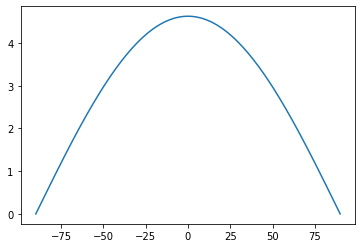

In [5]:
test_Lat = np.linspace(-90,90,180)
test_y = ground_vel(test_Lat)
plt.plot(test_Lat,test_y)
plt.show()

In [6]:
# Create a Map with the shape of height_data.shape
Lat_steps_n = height_data.shape[0]
ground_speed_Lat_vec = np.zeros(Lat_steps_n)
for i in range(Lat_steps_n):
    Lat = 90 - i * 180/Lat_steps_n - 0.5* 180/Lat_steps_n
    ground_speed_Lat_vec[i] = ground_vel(Lat)
ground_speed_data = np.transpose(ground_speed_Lat_vec* np.transpose(np.array([[1]*height_data.shape[1]])))

In [7]:
print(ground_speed_data)

[[0.00063056 0.00063056 0.00063056 ... 0.00063056 0.00063056 0.00063056]
 [0.00189168 0.00189168 0.00189168 ... 0.00189168 0.00189168 0.00189168]
 [0.0031528  0.0031528  0.0031528  ... 0.0031528  0.0031528  0.0031528 ]
 ...
 [0.0031528  0.0031528  0.0031528  ... 0.0031528  0.0031528  0.0031528 ]
 [0.00189168 0.00189168 0.00189168 ... 0.00189168 0.00189168 0.00189168]
 [0.00063056 0.00063056 0.00063056 ... 0.00063056 0.00063056 0.00063056]]


In [ ]:
plot_map(ground_speed_data,1,'velocity [m/s]',tuple((-90,90)),tuple((-180,180)),labelsize=18,cmap='Blues',i_steps=[1,2,3,4],save="ground_speed.png")

# Destination: Lunar Gateway - Near Rectilinear Halo Orbit (NRHO) - Polar
Theoretical minimum via Hohmann-Transfers and impulsive maneuvers

| Maneuver | Description                                                            |
|-----------|------------------------------------------------------------------------|
| I         | a) reduce initial groundspeed v0(Lat,Lon) to zero (perpendicular to orbit) <br> b) Accelerate to orbital speed at h=0 <br> --> heading to pole (set inclination = 90°) <br> c) Raise Apo to LLO   |
| II        | Raise Peri to LLO                                                      |
| III       | Raise Apo to NRHO_Peri                                                 |
| IV        | a) Lon of ascending Node alignment by waiting in orbit <br> b) Raise Peri to become Apo with NRHO_Apo |

![image.png](doc/img/trajectory_merged.png)

## Maneuvers

In [8]:
def orb_vel(r):
    return np.sqrt((G * m_moon)/(r)) # [m/s]

def orb_vel_ellip(r,a):
    return np.sqrt((G * m_moon) * ( (2/r)-(1/a) )) # [m/s]

In [125]:
r_moon

1737400

In [9]:
# Heightmap extrema:   min:    -9.115 [km]   max:    10.757 [km] to reference radius 1737.4 [km]
# Radius extrema:      min:  1728.285 [km]   max:  1748.157 [km]
# Orbital radius LLO:        1750.157 [km]  <- 2 km over highest point
# Altitude  gain:      max:    21.872 [km]   min:     2.000 [km]

orbital_r = r_moon + 100_000 #= 1_750_157 # [m] transfer LLO
NHRO_r_peri = 3_000_000 + r_moon # [m]
NHRO_r_apo = 70_000_000 + r_moon # [m]

### I) Ascent
- from h0,v0 to orbital speed on ground level
- raise Apo to LLO
(initiate first Hohman transfer)

In [89]:
# deltaV from start_radius with v=0 to orbital_radius:
# IDEAL SEQUENCE:
#    v1 - a) instantaneous burn to orbital velocity at ground level while countering ground velocity
#       - b) initiate Hohman Transfer (Raise Apo to LLO)
#    v2 - Hohman Transfer from start_radius to orbital_radius

def maneuver_I(start_r, start_vel):
    v0 = start_vel
    a = (start_r + orbital_r)/2 # [m] semi major axis of transfer ellipse to LLO
    v1 = orb_vel(start_r)
    v2_H1 = orb_vel_ellip(start_r,a) - orb_vel(start_r)
    
    dv_m1 = np.sqrt(v0**2 + (v1 + v2_H1)**2) # vector norm - v0 is perpendicular to v1 and v2_H1
    return dv_m1 # [m/s]

### II) LLO circularization
- Raise Peri to LLO (finish first Hohman Transfer)

In [90]:
def maneuver_II(start_r):
    a = (start_r + orbital_r)/2 # [m] semi major axis of transfer ellipse to LLO
    v2_H2 = orb_vel(orbital_r) - orb_vel_ellip(orbital_r,a)
    
    return v2_H2 # [m/s]

### III) Raise Apo to NRHO_Peri
- Raise Apo to NRHO_Peri (initiate second Hohman transfer)

In [91]:
def maneuver_III():
    a1 = (orbital_r + NHRO_r_peri)/2 # [m] semi major axis of transfer ellipse from LLO to NRHO
    v3 = orb_vel_ellip(orbital_r,a1) - orb_vel(orbital_r)
    
    return v3 # [m/s]

### VI) Raise Peri to become Apo with NRHO_Apo
- Raise Peri (finish second Hohman transfer), Peri becomes Apo
- Raise Apo to NRHO Apo

In [92]:
def maneuver_VI():
    a1 = (orbital_r + NHRO_r_peri)/2  # [m] semi major axis of transfer ellipse from LLO to NRHO
    a2 = (NHRO_r_apo + NHRO_r_peri)/2 # [m] semi major axis of NRHO ellipse
    v4 = orb_vel_ellip(NHRO_r_peri,a2) - orb_vel_ellip(NHRO_r_peri,a1)
    
    return v4 # [m/s]

## Combined Maneuvers

In [93]:
# this step needs approx. 1 min to complete

r_data = height_data*1000+r_moon

dv_NRHO_1 = maneuver_I(r_data,ground_speed_data)
dv_NRHO_2 = maneuver_II(r_data)
dv_NRHO_3 = maneuver_III()
dv_NRHO_4 = maneuver_VI()

dv_map_NRHO = dv_NRHO_1 + dv_NRHO_2 + dv_NRHO_3 + dv_NRHO_4 # [m/s]

In [ ]:
dv_NRHO_est = np.max( 1.05*(dv_NRHO_1 + dv_NRHO_2) + dv_NRHO_3 + dv_NRHO_4) # [m/s] 5% margin on I and II for a more realistic ascent

In [94]:
print(f'dv_I:   {np.min(dv_NRHO_1):0.2f} - {np.max(dv_NRHO_1):0.2f} [m/s]')
print(f'dv_II:  {np.min(dv_NRHO_2):0.2f} - {np.max(dv_NRHO_2):0.2f} [m/s]')
print(f'dv_III: {dv_NRHO_3:0.2f} [m/s]')
print(f'dv_IV:  {dv_NRHO_4:0.2f} [m/s]')
print()
print(f'Total dv to NRHO: {np.min(dv_map_NRHO):0.5f} - {np.max(dv_map_NRHO):0.5f} [m/s]')
print(f'max with margin:  {dv_NRHO_est:0.2f} [m/s]')

dv_I:   1695.42 - 1709.88 [m/s]
dv_II:  20.46 - 25.19 [m/s]
dv_III: 327.44 [m/s]
dv_IV:  632.88 [m/s]

Total dv to NRHO: 2676.19484 - 2695.38418 [m/s]
max with margin:  2782.14 [m/s]


comparison with GMAT/to_NRHO.script

| Maneuver | this calculation [m/s] | GMAT [m/s]      |
|-----------|-----------|-----------|
| I a)      |   |    |
| I b)      |   |    |
| I c)      |   | 23.49069605835579   |
| II        | 20.46 - 25.19  | 23.25834783973138   |
| III       | 327.44  | 327.421104539017   |
| IV a)     | waiting  |  waiting  |
| IV b)     | 632.88  | 632.7652040357942   |


In [95]:
# cutting of precision to save on filesize (min = 2670.81020 -> 2670.81030, max = 2690.00489 -> 2690.00488)
print(f'from  {dv_map_NRHO.dtype} {type(dv_map_NRHO)} {dv_map_NRHO.dtype.itemsize*dv_map_NRHO.shape[0]*dv_map_NRHO.shape[1]/(1024*1024*1024):0.2f} GB')
dv_map_NRHO = dv_map_NRHO.astype(np.float32, copy=False)
print(f'to    {dv_map_NRHO.dtype} {type(dv_map_NRHO)} {dv_map_NRHO.dtype.itemsize*dv_map_NRHO.shape[0]*dv_map_NRHO.shape[1]/(1024*1024*1024):0.2f} GB')

from  float64 <class 'numpy.ndarray'> 1.98 GB
to    float32 <class 'numpy.ndarray'> 0.99 GB


In [96]:
# save data in xArray to file (~1GB of space)

Lat, Lon = LatLonfromShape(height_data.shape)

xA_dv_map_NRHO = xr.DataArray(
    data=dv_map_NRHO,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="DeltaV to Lunar Gateway (NRHO)",
        var_desc="deltaV",
        units="m/s",
    ),
)

xA_dv_map_NRHO.to_netcdf("maps/dv_map_NRHO.nc")

In [9]:
# load xArray from file
xA_dv_map_NRHO = xr.open_dataarray("maps/dv_map_NRHO.nc")
dv_map_NRHO = xA_dv_map_NRHO.data

In [ ]:
plot_map(dv_map_NRHO,1,'velocity [m/s]',tuple((-90,90)),tuple((-180,180)),labelsize=18,save="dv_map_NRHO.png")

## EL3 Sizing - Roundtrip Estimation
    → [1] Moon surface: load Payload (O2), refuel O2
    → [2] Transfer (Launch + Maneuvers)
    → [3] Destination: deliver Payload (O2), refuel H2
    → [4] Transfer (Launch + Maneuvers)
    → [1] ...

In [5]:
# EL3 initial data
# https://www.esa.int/Science_Exploration/Human_and_Robotic_Exploration/Exploration/Argonaut_European_Large_Logistics_Lander
EL3_wet_mass  = 8500 # [kg]
EL3_dry_mass  = 1600 # [kg]
EL3_prop_mass = EL3_wet_mass - EL3_dry_mass # [kg]
EL3_payload   = 1500 # [kg]

# EL3 assumption
EL3_I_sp = 400 # [s] specific impulse
of_ratio = 6 # [Ox/H] volumetric isp max

In [11]:
def maneuver_result_mass(EEV,m_0,deltaV):
    # from: deltaV = EEV * ln ( m_0 / m_f )
    m_f = m_0 * (1/ np.exp(deltaV/EEV))
    return m_f

def check_fuel(H2,O2,result_table):
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        return False
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        return False
    else:
        return True

# roundtrip calculation via deltaV estimations
def compute_roundtrip(dv, mass_full, payload, H2_initial, H2_refill, dest_name="Destination",printout=False):
    
    mass_dry = 1600
    of_ratio = 6
    I_sp = 400 # [s] specific impulse
    EEV = np.array(I_sp * g_0, dtype=np.float64) # [m/s] effective exhaust velocity
    
    initial_height = -9115 #-8.179428100585938 # lowest point on downsampled map
    mass = mass_full
    fuel = mass_full - mass_dry - payload
    H2_factor = (1/(of_ratio+1))
    O2_factor = (of_ratio/(of_ratio+1))
    H2 = H2_initial
    O2 = fuel - H2
    
    H2_initial = H2 # for comparing to the end state

    
    #logging in table
    result_table = PrettyTable([" ", "ΔV", "used fuel", "Δ H2", "Δ O2","mass","fuel left","H2","O2","payload"],float_format = "4.0")
    result_table.set_style(MARKDOWN)
    msg = False
    msg_H2 = False
    msg_O2 = False
    
    
    #__________________________________
    # Lunar surface starting condition
    result_table.add_row(["Lunar Surface", "", "", "" , f"+{O2}" , mass, fuel, H2, O2, f'+{payload}' ])
    
    #__________________________________
    # apply launch and maneuver segment
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,dv)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Maneuvers", dv, fuel_used, -H2_factor * fuel_used, -O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    # check H2 for optimization
    if H2 < 1 and H2 > 0:
        msg_H2 = True
    if H2 > 1:
        msg = "H2 leftover"
    
    #__________________________________
    # Gateway exchange
    
    H2 += H2_refill
    fuel = O2 + H2
    mass = mass_dry + fuel
    
    result_table.add_row(["Gateway exchange", "", "", "+"+str(H2_refill),"", mass, fuel, H2, O2, "-"+str(payload) ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    #__________________________________
    # apply maneuver and landing segment
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,dv)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Maneuvers", dv , fuel_used, -H2_factor * fuel_used, -O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    if H2 < H2_initial:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 insufficient", msg
    
    # check O2 for optimization
    if O2 < 1 and O2 > 0:
        msg_O2 = True
    if O2 > 1:
        msg = "O2 leftover"
    
    if msg_H2 == True and msg_O2 == True:
        msg = True
    
    result_table.add_row(["=== SUCCESS ===", "====", "====", "====" , "====" , "====", "====", "====", "====", "====" ])
    if printout: print(result_table, end="\n \n")
    return True, msg

In [12]:
# normal EL3 config is insufficient
compute_roundtrip(dv=np.min(dv_map_NRHO),mass_full=8500,payload=1500,H2_initial=600.5,H2_refill=858,dest_name="NRHO",printout=True)

|                  |     ΔV    | used fuel | Δ H2 |   Δ O2  | mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:---------:|:---------:|:----:|:-------:|:----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |           |           |      | +4799.5 | 8500 |    5400   |  600 |  4800 |  +1500  |
|    Maneuvers     | 2676.1948 |    4203   | -600 |  -3603  | 4297 |    1197   |    0 |  1197 |         |
| Gateway exchange |           |           | +858 |         | 3655 |    2055   |  858 |  1197 |  -1500  |
|    Maneuvers     | 2676.1948 |    1807   | -258 |  -1549  | 3347 |     247   |  600 |  -352 |         |
|      ABORT       |           |           |      |         |      |           |      | EMPTY |         |
 


('O2 empty', False)

### Upscaling
Because the standard EL3 configuration is insufficient to carry out the roundtrip<br>
> the launcher (propellant) is scaled up, while keeping the mass_dry constant at 1600 kg
<br>

Assumption: the propulsion system still carries out maneuvers as estimated and structure mass stays constant<br>
Limitation: mass ratio increases with upscaling - pseudo efficiency increase

In [6]:
def converge_NRHO_roundtrip(payload,dv,dest_name="NRHO",silent=False,info=False):
    # init values
    wet_mass_loop = 2*payload # for faster convergence
    H2_initial_loop = 100
    H2_refill_loop = 100
    
    while True:
        ans, msg = False, False
        ans, msg = compute_roundtrip(dv,wet_mass_loop,payload,H2_initial_loop,H2_refill_loop,dest_name)
        if ans == "O2 empty":
            if payload > 20000: wet_mass_loop += 100 # for faster convergence with big rockets
            else: wet_mass_loop += 1
        if ans == "H2 empty":
            H2_initial_loop += 1
            H2_refill_loop += 1
        if ans == "H2 insufficient":
            H2_refill_loop += 1
        if msg == "H2 leftover":
            H2_initial_loop -= 1
        if msg == "O2 leftover":
            wet_mass_loop -= 1
        
        if not silent: print(f'{wet_mass_loop:5.0f} {H2_initial_loop:5.0f} {H2_refill_loop:5.0f} {bool(ans)} {bool(msg)}', end=" \r") # for debugging
            
        if ans == True and msg == True:
            if not silent: print()
            break


    if not silent: compute_roundtrip(dv,wet_mass_loop,payload,H2_initial_loop,H2_refill_loop,dest_name,printout=True)
    
    if info: return wet_mass_loop, H2_refill_loop, H2_initial_loop
    else: 
        return wet_mass_loop, H2_refill_loop

In [15]:
# Standard El3 mass ratio (8500 kg wet/ 1600 kg dry) - less payload (Exchange Ratio 0.9:1)
converge_NRHO_roundtrip(808,np.max(dv_map_NRHO))

 8500   604   915 True True   
|                  |     ΔV    | used fuel | Δ H2 |  Δ O2 | mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:---------:|:---------:|:----:|:-----:|:----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |           |           |      | +5488 | 8500 |    6092   | 604  | 5488 |   +808  |
|    Maneuvers     | 2695.3843 |    4224   | -603 | -3621 | 4276 |    1868   |    1 | 1867 |         |
| Gateway exchange |           |           | +915 |       | 4383 |    2783   |  916 | 1867 |   -808  |
|    Maneuvers     | 2695.3843 |    2178   | -311 | -1867 | 3013 |     605   |  604 |    0 |         |
| === SUCCESS ===  |    ====   |    ====   | ==== |  ==== | ==== |    ====   | ==== | ==== |   ====  |
 


(8500, 915)

In [105]:
# Standard El3 Payload (1500 kg) - in upscaled version (Exchange Ratio 1.44:1)
converge_NRHO_roundtrip(1500,np.max(dv_map_NRHO))

10063   715  1042 True True      
|                  |     ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |           |           |       | +6248 | 10063 |    6963   | 715  | 6248 |  +1500  |
|    Maneuvers     | 2695.3843 |    5001   |  -714 | -4287 |  5062 |    1962   |    1 | 1961 |         |
| Gateway exchange |           |           | +1042 |       |  4604 |    3004   | 1043 | 1961 |  -1500  |
|    Maneuvers     | 2695.3843 |    2288   |  -327 | -1961 |  3816 |     716   |  716 |    0 |         |
| === SUCCESS ===  |    ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(10063, 1042)

In [106]:
# Exchange Ratio 1.5:1
converge_NRHO_roundtrip(1585,np.max(dv_map_NRHO))

10236   727  1056 True True      
|                  |     ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |           |           |       | +6332 | 10236 |    7059   | 727  | 6332 |  +1577  |
|    Maneuvers     | 2695.3843 |    5087   |  -727 | -4360 |  5149 |    1972   |    0 | 1972 |         |
| Gateway exchange |           |           | +1056 |       |  4628 |    3028   | 1056 | 1972 |  -1577  |
|    Maneuvers     | 2695.3843 |    2300   |  -329 | -1971 |  3905 |     728   |  728 |    0 |         |
| === SUCCESS ===  |    ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(10236, 1056)

In [21]:
# Exchange Ratio 2:1
converge_NRHO_roundtrip(2420,np.max(dv_map_NRHO))

12083   857  1203 True True      
|                  |    ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:--------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |          |           |       | +7216 | 12083 |    8073   | 857  | 7216 |  +2410  |
|    Maneuvers     | 2690.005 |    5997   |  -857 | -5140 |  6086 |    2076   |    0 | 2076 |         |
| Gateway exchange |          |           | +1203 |       |  4879 |    3279   | 1203 | 2076 |  -2410  |
|    Maneuvers     | 2690.005 |    2422   |  -346 | -2076 |  4868 |     858   |  857 |    0 |         |
| === SUCCESS ===  |   ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(12083, 1203)

In [80]:
# Exchange Ratio 2.5:1
converge_NRHO_roundtrip(3535,np.max(dv_map_NRHO))

14549  1032  1402 True True      
|                  |    ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:--------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |          |           |       | +8412 | 14549 |    9444   | 1032 | 8412 |  +3505  |
|    Maneuvers     | 2690.005 |    7221   | -1032 | -6189 |  7328 |    2223   |    0 | 2223 |         |
| Gateway exchange |          |           | +1402 |       |  5225 |    3625   | 1402 | 2223 |  -3505  |
|    Maneuvers     | 2690.005 |    2593   |  -370 | -2223 |  6137 |    1032   | 1032 |    0 |         |
| === SUCCESS ===  |   ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(14549, 1402)

In [13]:
# Exchange Ratio 3:1
converge_NRHO_roundtrip(5100,np.max(dv_map_NRHO))

18191  1292  1700 True True       
|                  |     ΔV    | used fuel |  Δ H2 |  Δ O2  |  mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:------:|:-----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |           |           |       | +10199 | 18191 |   11491   | 1292 | 10199 |  +5100  |
|    Maneuvers     | 2695.3843 |    9041   | -1292 | -7749  |  9150 |    2450   |    0 |  2450 |         |
| Gateway exchange |           |           | +1700 |        |  5750 |    4150   | 1700 |  2450 |  -5100  |
|    Maneuvers     | 2695.3843 |    2858   |  -408 | -2450  |  7993 |    1293   | 1292 |     0 |         |
| === SUCCESS ===  |    ====   |    ====   |  ==== |  ====  |  ==== |    ====   | ==== |  ==== |   ====  |
 


(18191, 1700)

In [14]:
# prepare data for plotting
x_payload = np.linspace(1,6000,100)
y1 = []
y2 = []
for i in tqdm(x_payload):
    ans1 , ans2 = converge_NRHO_roundtrip(i,np.max(dv_map_NRHO),silent=True)
    y1.append(ans1)
    y2.append(ans2)
x = np.array(x_payload)
y1 = np.array(y1)
y2 = np.array(y2)
ex_ratio = x/y2
m_ratio = y1/1600 # constant dry_mass of 1600 kg

x_points = [808,1500,1585,2420,3535,5100]
y1_points = []
y2_points = []
for i in tqdm(x_points):
    ans1 , ans2 = converge_NRHO_roundtrip(i,np.max(dv_map_NRHO),silent=True)
    y1_points.append(ans1)
    y2_points.append(ans2)
x_points = np.array(x_points)
y1_points = np.array(y1_points)
y1_points_ratio = y1_points/1600
y2_points = np.array(y2_points)
y2_points_ratio = x_points/y2_points

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

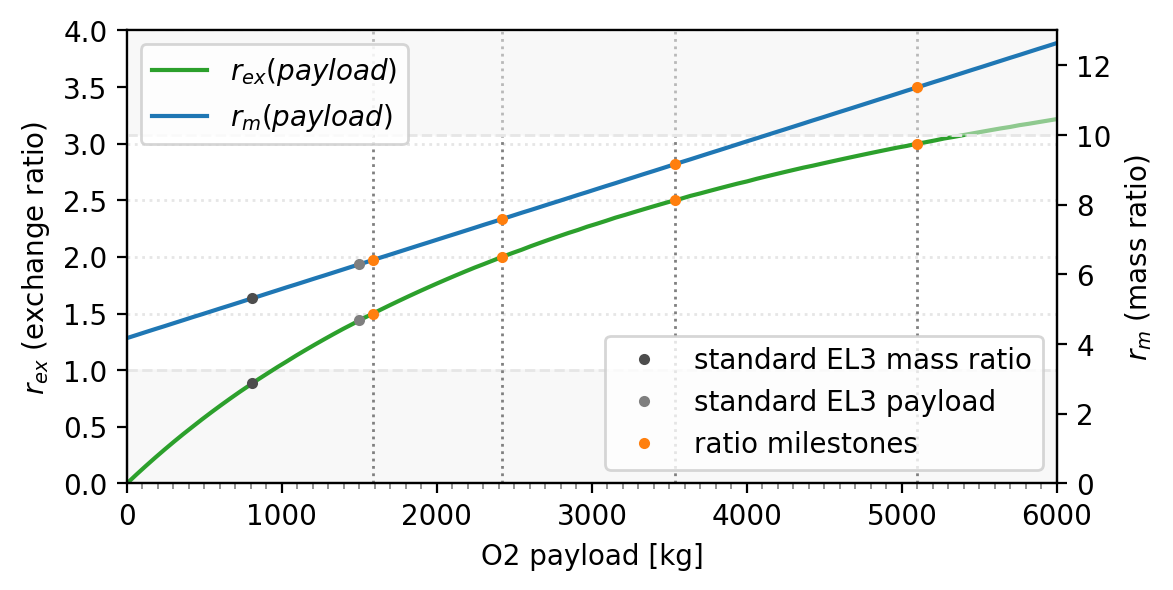

In [124]:
# plot Exchange Ratio: Oxygen for Hydrogen
# plot Mass Ratio of Launcher

#plt.figure(figsize=(6,3), dpi=200)
fig, ax1 = plt.subplots(figsize=(6,3),dpi=200)
ax2 = ax1.twinx()

#plt.title("Lunar Gateway: Mass Exchange ratio of O2 for H2")
ax1.set_xlim(0, max(x_payload))
ax1.set_ylim(0, 4)

ax1.axhspan(0, 1, color='0.95', alpha=0.5,ls='--')
ax1.axhline(y=1.0,linewidth=1, color='0.9',linestyle="--")
ax1.axhline(y=1.5,linewidth=1, color='0.9',linestyle=":")
ax1.axhline(y=2.0,linewidth=1, color='0.9',linestyle=":")
ax1.axhline(y=2.5,linewidth=1, color='0.9',linestyle=":")
ax1.axhline(y=3.0,linewidth=1, color='0.9',linestyle=":")
ax1.axvline(x=x_points[2],linewidth=1, color='0.5',linestyle=":")
ax1.axvline(x=x_points[3],linewidth=1, color='0.5',linestyle=":")
ax1.axvline(x=x_points[4],linewidth=1, color='0.5',linestyle=":")
ax1.axvline(x=x_points[5],linewidth=1, color='0.5',linestyle=":")
ax1.plot(x,ex_ratio,c='tab:green') #label='ratio as f(payload)'
ax1.plot(x_points[0],y2_points_ratio[0],'.',color='0.3',label='standard EL3 mass ratio')
ax1.plot(x_points[1],y2_points_ratio[1],'.',color='tab:grey',label='standard EL3 payload')
ax1.plot(x_points[2:],y2_points_ratio[2:],'.',color='tab:orange',label='ratio milestones')
ax1.set_ylabel("$r_{ex}$ (exchange ratio)")
ax1.set_xlabel("O2 payload [kg]")

ax1.xaxis.set_major_locator(MultipleLocator(1000))
ax1.xaxis.set_minor_locator(MultipleLocator(100))
ax1.tick_params(axis='x', which='minor', colors='0.5')

ax2.set_xlim(0, max(x_payload))
ax2.set_ylim(0, 13)
ax2.axhspan(10, 13, color='0.95', alpha=0.5,ls='--')
ax2.axhline(y=10 ,linewidth=1, color='0.9',linestyle="--")
ax2.plot(-1,-1,c='tab:green',label="$r_{ex} (payload)$") # workaround to get this label here
ax2.plot(x,m_ratio,color='tab:blue',label="$r_m (payload)$")
ax2.plot(x_points[0],y1_points_ratio[0],'.',color='0.3')
ax2.plot(x_points[1],y1_points_ratio[1],'.',color='tab:grey')
ax2.plot(x_points[2:],y1_points_ratio[2:],'.',color='tab:orange')
ax2.set_ylabel("$r_{m}$ (mass ratio)")
ax2.set_xlabel("O2 payload [kg]")

ax2.legend(loc='upper left')
ax1.legend(loc='lower right')

ax2.set_axisbelow(True)
ax2.xaxis.set_major_locator(MultipleLocator(1000))
ax2.xaxis.set_minor_locator(MultipleLocator(100))
ax2.tick_params(axis='x', which='minor', colors='0.5')

plt.savefig('doc\\img\\upscale_ratios.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

### A) upscaled version with **1.5** exchange ratio

#### dv Maximum

In [125]:
Launcher_dry_mass = 1600
Launcher_payload = 1585
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.max(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("     LAUNCHER SPECIFICATION")
print("     for global dv Maximum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

10253   728  1057 True True     
|                  |     ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |           |           |       | +6340 | 10253 |    7068   | 728  | 6340 |  +1585  |
|    Maneuvers     | 2695.3843 |    5096   |  -728 | -4368 |  5157 |    1972   |    0 | 1972 |         |
| Gateway exchange |           |           | +1057 |       |  4629 |    3029   | 1057 | 1972 |  -1585  |
|    Maneuvers     | 2695.3843 |    2301   |  -329 | -1972 |  3914 |     729   |  728 |    0 |         |
| === SUCCESS ===  |    ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
     LAUNCHER SPECIFICATION
     for global dv Maximum
┌────────────────┬──────────────┐
│    wet mass    │   10253 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    1585 [kg] │
│   O2 refill    │    6340 [kg] │
│   H

#### dv Minimum

In [129]:
Launcher_dry_mass = 1600
Launcher_payload = 1555
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.min(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("     LAUNCHER SPECIFICATION")
print("     for global dv Minimum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

10083   713  1037 True True    
|                  |     ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |           |           |       | +6215 | 10083 |    6928   | 713  | 6215 |  +1555  |
|    Maneuvers     | 2676.1948 |    4986   |  -712 | -4274 |  5097 |    1942   |    1 | 1941 |         |
| Gateway exchange |           |           | +1037 |       |  4579 |    2979   | 1038 | 1941 |  -1555  |
|    Maneuvers     | 2676.1948 |    2264   |  -323 | -1941 |  3870 |     715   |  714 |    0 |         |
| === SUCCESS ===  |    ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
     LAUNCHER SPECIFICATION
     for global dv Minimum
┌────────────────┬──────────────┐
│    wet mass    │   10083 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    1555 [kg] │
│   O2 refill    │    6215 [kg] │
│   H2

### B) upscaled version with **2.5** exchange ratio

#### dv Maximum

In [131]:
Launcher_dry_mass = 1600
Launcher_payload = 3535
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.max(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("     LAUNCHER SPECIFICATION")
print("     for global dv Maximum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

14657  1041  1414 True True     
|                  |     ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |           |           |       | +8481 | 14657 |    9522   | 1041 | 8481 |  +3535  |
|    Maneuvers     | 2695.3843 |    7284   | -1041 | -6244 |  7373 |    2238   |    0 | 2237 |         |
| Gateway exchange |           |           | +1414 |       |  5252 |    3652   | 1414 | 2237 |  -3535  |
|    Maneuvers     | 2695.3843 |    2610   |  -373 | -2237 |  6177 |    1042   | 1042 |    0 |         |
| === SUCCESS ===  |    ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
     LAUNCHER SPECIFICATION
     for global dv Maximum
┌────────────────┬──────────────┐
│    wet mass    │   14657 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    3535 [kg] │
│   O2 refill    │    8481 [kg] │
│   H

#### dv Minimum (keep Mass Ratio constant)

In [136]:
Launcher_dry_mass = 1600
Launcher_payload = 3440
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.min(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("     LAUNCHER SPECIFICATION")
print("     for global dv Minimum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

14304  1011  1376 True True   
|                  |     ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |           |           |       | +8253 | 14304 |    9264   | 1011 | 8253 |  +3440  |
|    Maneuvers     | 2676.1948 |    7074   | -1011 | -6063 |  7230 |    2190   |    0 | 2190 |         |
| Gateway exchange |           |           | +1376 |       |  5166 |    3566   | 1376 | 2190 |  -3440  |
|    Maneuvers     | 2676.1948 |    2555   |  -365 | -2190 |  6052 |    1012   | 1012 |    0 |         |
| === SUCCESS ===  |    ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
     LAUNCHER SPECIFICATION
     for global dv Minimum
┌────────────────┬──────────────┐
│    wet mass    │   14304 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    3440 [kg] │
│   O2 refill    │    8253 [kg] │
│   H2 

## Mass Costs per Year (quick analysis)

In [139]:
# both (min/max) using up the 23.9 t Oxygen per year
# for A) Ex = 1.5
# apply 23.9 t Oxygen Supply

#     LAUNCHER SPECIFICATION
#     for global dv Maximum
#┌────────────────┬──────────────┐
#│    wet mass    │   10253 [kg] │
#│    dry mass    │    1600 [kg] │
#│    payload     │    1585 [kg] │
#│   O2 refill    │    6340 [kg] │
#│   H2 refill    │    1057 [kg] │
#│   Mass Ratio   │   6.408      │
#│ Exchange Ratio │   1.500      │
#└────────────────┴──────────────┘
#     LAUNCHER SPECIFICATION
#     for global dv Minimum
#┌────────────────┬──────────────┐
#│    wet mass    │   10083 [kg] │
#│    dry mass    │    1600 [kg] │
#│    payload     │    1555 [kg] │
#│   O2 refill    │    6215 [kg] │
#│   H2 refill    │    1037 [kg] │
#│   Mass Ratio   │   6.302      │
#│ Exchange Ratio │   1.500      │
#└────────────────┴──────────────┘


# compare fuel costs for delivering the same amount of payload [1kg]
maxdv_payload = 1585 # [kg]
maxdv_O2_consumption = 6340 # [kg]
maxdv_H2_consumption = 1057 # [kg]
maxdv_Fuel_consumption = maxdv_O2_consumption + maxdv_H2_consumption
maxdv_costs_per_kg = maxdv_Fuel_consumption / maxdv_payload

print(f'maxdv_costs_per_kg = {maxdv_costs_per_kg:5.3f} [kg Fuel/ kg Payload]')

mindv_payload = 1555 # [kg]
mindv_O2_consumption = 6215 # [kg]
mindv_H2_consumption = 1037 # [kg]
mindv_Fuel_consumption = mindv_O2_consumption + mindv_H2_consumption
mindv_costs_per_kg = mindv_Fuel_consumption / mindv_payload

print(f'mindv_costs_per_kg = {mindv_costs_per_kg:5.3f} [kg Fuel/ kg Payload]')
print()

maxdv_costs_per_year = 23.9 * 1000 * maxdv_costs_per_kg

print(f'maxdv_costs_per_year = {maxdv_costs_per_year:5.2f} [kg Fuel/ year]')

mindv_costs_per_year = 23.9 * 1000 * mindv_costs_per_kg

print(f'mindv_costs_per_year = {mindv_costs_per_year:5.2f} [kg Fuel/ year]')

maxdv_costs_per_kg = 4.667 [kg Fuel/ kg Payload]
mindv_costs_per_kg = 4.664 [kg Fuel/ kg Payload]

maxdv_costs_per_year = 111538.36 [kg Fuel/ year]
mindv_costs_per_year = 111461.61 [kg Fuel/ year]


## Cost per year map
as converge_NRHO_roundtrip() takes ~2 sec to finish an iterative solving of the (23040, 11520) data is not practical (16.8 years)
<br>
however the relationship from dv to the costs per kg can be sampled into a fitting function to supply an easy mapping

### fitting data
vary dv and keep mass ratio constant

In [13]:
def cost_from_dv_via_mass_ratio(mass_ratio,dv,start_value):
    tolerance = 0.01
    increment = 10
    
    Launcher_dry_mass = 1600
    Launcher_payload = start_value
    
    while True:
        Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,dv,info=True,silent=True)
        Launcher_mass_ratio = Launcher_wet_mass/Launcher_dry_mass
        
        if Launcher_mass_ratio < mass_ratio + tolerance and Launcher_mass_ratio > mass_ratio - tolerance :
            break
        elif Launcher_mass_ratio < mass_ratio:
            Launcher_payload += increment
        elif Launcher_mass_ratio > mass_ratio:
            Launcher_payload -= increment
            
    Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial
    
    Fuel_consumption = Launcher_O2_refill + Launcher_H2_refill
    spent_fuel_per_kg = Fuel_consumption / Launcher_payload
    spent_O2_per_kg = Launcher_O2_refill / Launcher_payload
    spent_H2_per_kg = Launcher_H2_refill / Launcher_payload
    
    return spent_fuel_per_kg, spent_O2_per_kg, spent_H2_per_kg

In [14]:
# takes approx. 10 min to complete

mass_ratio_1_5 = 6.408
mass_ratio_2_5 = 9.161

x = np.linspace(np.min(dv_map_NRHO),np.max(dv_map_NRHO),100)

u_1_5 = np.zeros(x.shape) # total fuel / kg payload
v_1_5 = np.zeros(x.shape) # O2 / kg payload
w_1_5 = np.zeros(x.shape) # H2 / kg payload

u_2_5 = np.zeros(x.shape) # total fuel / kg payload
v_2_5 = np.zeros(x.shape) # O2 / kg payload
w_2_5 = np.zeros(x.shape) # H2 / kg payload


with tqdm(total=len(x)*2) as pbar:    
    for i , value in enumerate(x):
        u_1_5[i] , v_1_5[i] , w_1_5[i] = cost_from_dv_via_mass_ratio(mass_ratio_1_5,value,start_value=1600) # 1.5 exchange ratio
        pbar.update(1)
        u_2_5[i] , v_2_5[i] , w_2_5[i] = cost_from_dv_via_mass_ratio(mass_ratio_2_5,value,start_value=3500) # 2.5 exchange ratio
        pbar.update(1)

  0%|          | 0/200 [00:00<?, ?it/s]

f(x)_1.5 = 0.00816625407891151*x + -17.34758874602394
f(x)_2.5 = 0.003512663660565612*x + -6.668219229727147


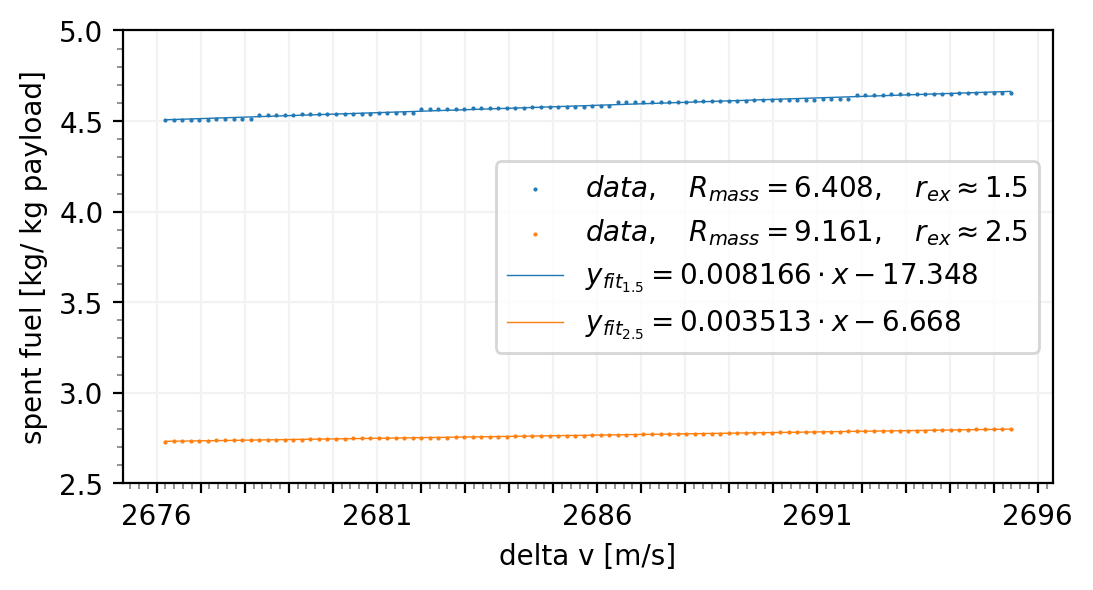

In [16]:
# (u) total spent fuel
#-------------------------------------------------
# linear fit
m_1_5, n_1_5 = np.polyfit(x, u_1_5, 1)
m_2_5, n_2_5 = np.polyfit(x, u_2_5, 1)
y_pred_1_5 = m_1_5 * x + n_1_5
y_pred_2_5 = m_2_5 * x + n_2_5
print(f'f(x)_1.5 = {m_1_5}*x + {n_1_5}')
print(f'f(x)_2.5 = {m_2_5}*x + {n_2_5}')

plt.figure(figsize=(6,3), dpi=200)

#plt.title("total spent fuel mapping from delta v")
plt.grid(axis='both', color='0.95')

plt.scatter(x,u_1_5,marker='.', s=1, color='tab:blue',label=r'$data, \quad R_{mass}=6.408, \quad r_{ex} \approx 1.5$')
plt.scatter(x,u_2_5,marker='.', s=1, color='tab:orange',label=r'$data, \quad R_{mass}=9.161, \quad r_{ex} \approx 2.5$')

plt.plot(x,y_pred_1_5,label=r'$y_{fit_{1.5}}= 0.008166 \cdot x -17.348$', linewidth=0.5)
plt.plot(x,y_pred_2_5,label=r'$y_{fit_{2.5}}= 0.003513 \cdot x -6.668$', linewidth=0.5)

plt.ylabel("spent fuel [kg/ kg payload]")
plt.xlabel("delta v [m/s]")
plt.legend()
plt.ylim(2.5,5)
ax = plt.gca()
ax.set_axisbelow(True)
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 5 != 1:
        label.set_visible(False)
ax.tick_params(axis='y', which='minor', colors='0.5')
ax.tick_params(axis='x', which='minor', colors='0.5')
plt.savefig('doc\\img\\spent_total_mapping.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

spent O2
f(x)_1.25 = 0.007000074102812633*x + -14.870711441547764
f(x)_1.5  = 0.003010335371726332*x + -5.714307819335437
spent H2
f(x)_1.5 = 0.0011661799760988758*x + -2.47687730447618
f(x)_2.5 = 0.0005023282888392832*x + -0.9539114103917207


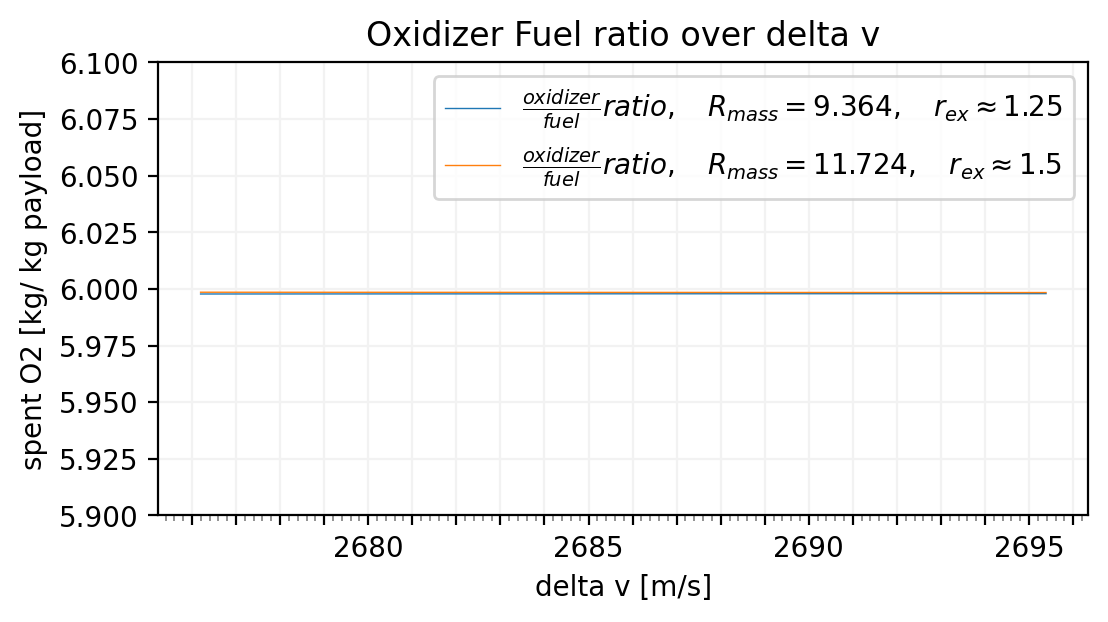

In [152]:
# (v) spent O2
#-------------------------------------------------
# linear fit
m_O2_1_5, n_O2_1_5 = np.polyfit(x, v_1_5, 1)
m_O2_2_5, n_O2_2_5 = np.polyfit(x, v_2_5, 1)
y_O2_pred_1_5 = m_O2_1_5 * x + n_O2_1_5
y_O2_pred_2_5 = m_O2_2_5 * x + n_O2_2_5
print('spent O2')
print(f'f(x)_1.25 = {m_O2_1_5}*x + {n_O2_1_5}')
print(f'f(x)_1.5  = {m_O2_2_5}*x + {n_O2_2_5}')

# (w) spent H2
#-------------------------------------------------
# linear fit
m_H2_1_5, n_H2_1_5 = np.polyfit(x, w_1_5, 1)
m_H2_2_5, n_H2_2_5 = np.polyfit(x, w_2_5, 1)
y_H2_pred_1_5 = m_H2_1_5 * x + n_H2_1_5
y_H2_pred_2_5 = m_H2_2_5 * x + n_H2_2_5
print('spent H2')
print(f'f(x)_1.5 = {m_H2_1_5}*x + {n_H2_1_5}')
print(f'f(x)_2.5 = {m_H2_2_5}*x + {n_H2_2_5}')

plt.figure(figsize=(6,3), dpi=200)

plt.title("Oxidizer Fuel ratio over delta v")
plt.grid(axis='both', color='0.95')


plt.plot(x,(y_O2_pred_1_5/y_H2_pred_1_5),label=r'$\frac{oxidizer}{fuel} ratio, \quad R_{mass}=9.364, \quad r_{ex} \approx 1.25$', linewidth=0.5)
plt.plot(x,(y_O2_pred_2_5/y_H2_pred_2_5),label=r'$\frac{oxidizer}{fuel} ratio, \quad R_{mass}=11.724, \quad r_{ex} \approx 1.5$', linewidth=0.5)


#plt.yscale('log')
plt.ylim(5.9,6.1)
plt.ylabel("spent O2 [kg/ kg payload]")
plt.xlabel("delta v [m/s]")
plt.legend()
ax = plt.gca()
#ax.yaxis.set_minor_locator(MultipleLocator(0.02))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
#ax.tick_params(axis='y', which='minor', colors='0.5')
ax.tick_params(axis='x', which='minor', colors='0.5')
plt.savefig('doc\\img\\of_ratio.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
# -> due to constant o/f ratio the constitution of total spent fuel stays constant
# => only save total spent fuel and get O2 and H2 by of_ratio

In [153]:
of_ratio = 6
O2_factor = (of_ratio/(of_ratio+1))
H2_factor = (1/(of_ratio+1))

def spent_total_mapping_1_5(dv):
    # m_1_5 = 0.00816625407891151
    # n_1_5 = -17.34758874602394
    mass = 0.00816625407891151 * dv -17.34758874602394
    return mass

def spent_total_mapping_2_5(dv):
    # m_2_5 = 0.003512663660565612
    # n_2_5 = -6.668219229727147
    mass = 0.003512663660565612 * dv -6.668219229727147
    return mass

def spent_O2_mapping_1_5(dv):
    mass = O2_factor * spent_total_mapping_1_5(dv)
    return mass

def spent_O2_mapping_2_5(dv):
    mass = O2_factor * spent_total_mapping_2_5(dv)
    return mass

def spent_H2_mapping_1_5(dv):
    mass = H2_factor * spent_total_mapping_1_5(dv)
    return mass

def spent_H2_mapping_2_5(dv):
    mass = H2_factor * spent_total_mapping_2_5(dv)
    return mass

In [156]:
spent_fuel_NRHO_1_5 = spent_total_mapping_1_5(dv_map_NRHO)
spent_fuel_NRHO_2_5 = spent_total_mapping_2_5(dv_map_NRHO)

In [159]:
# save data in xArray to file (~1GB of space)

Lat, Lon = LatLonfromShape(height_data.shape)

xA_spent_fuel_NRHO_1_5 = xr.DataArray(
    data=spent_fuel_NRHO_1_5,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="spent fuel per kg payload to Lunar Gateway (NRHO) with an exchange ratio of approx. 1.5 (mass ratio of 9.364)",
        var_desc="spent fuel",
        units="kg",
    ),
)

xA_spent_fuel_NRHO_1_5.to_netcdf("maps/spent_fuel_NRHO_1_5.nc")

In [160]:
# save data in xArray to file (~1GB of space)

Lat, Lon = LatLonfromShape(height_data.shape)

xA_spent_fuel_NRHO_2_5 = xr.DataArray(
    data=spent_fuel_NRHO_2_5,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="spent fuel per kg payload to Lunar Gateway (NRHO) with an exchange ratio of approx. 2.5 (mass ratio of 11.724)",
        var_desc="spent fuel",
        units="kg",
    ),
)

xA_spent_fuel_NRHO_2_5.to_netcdf("maps/spent_fuel_NRHO_2_5.nc")

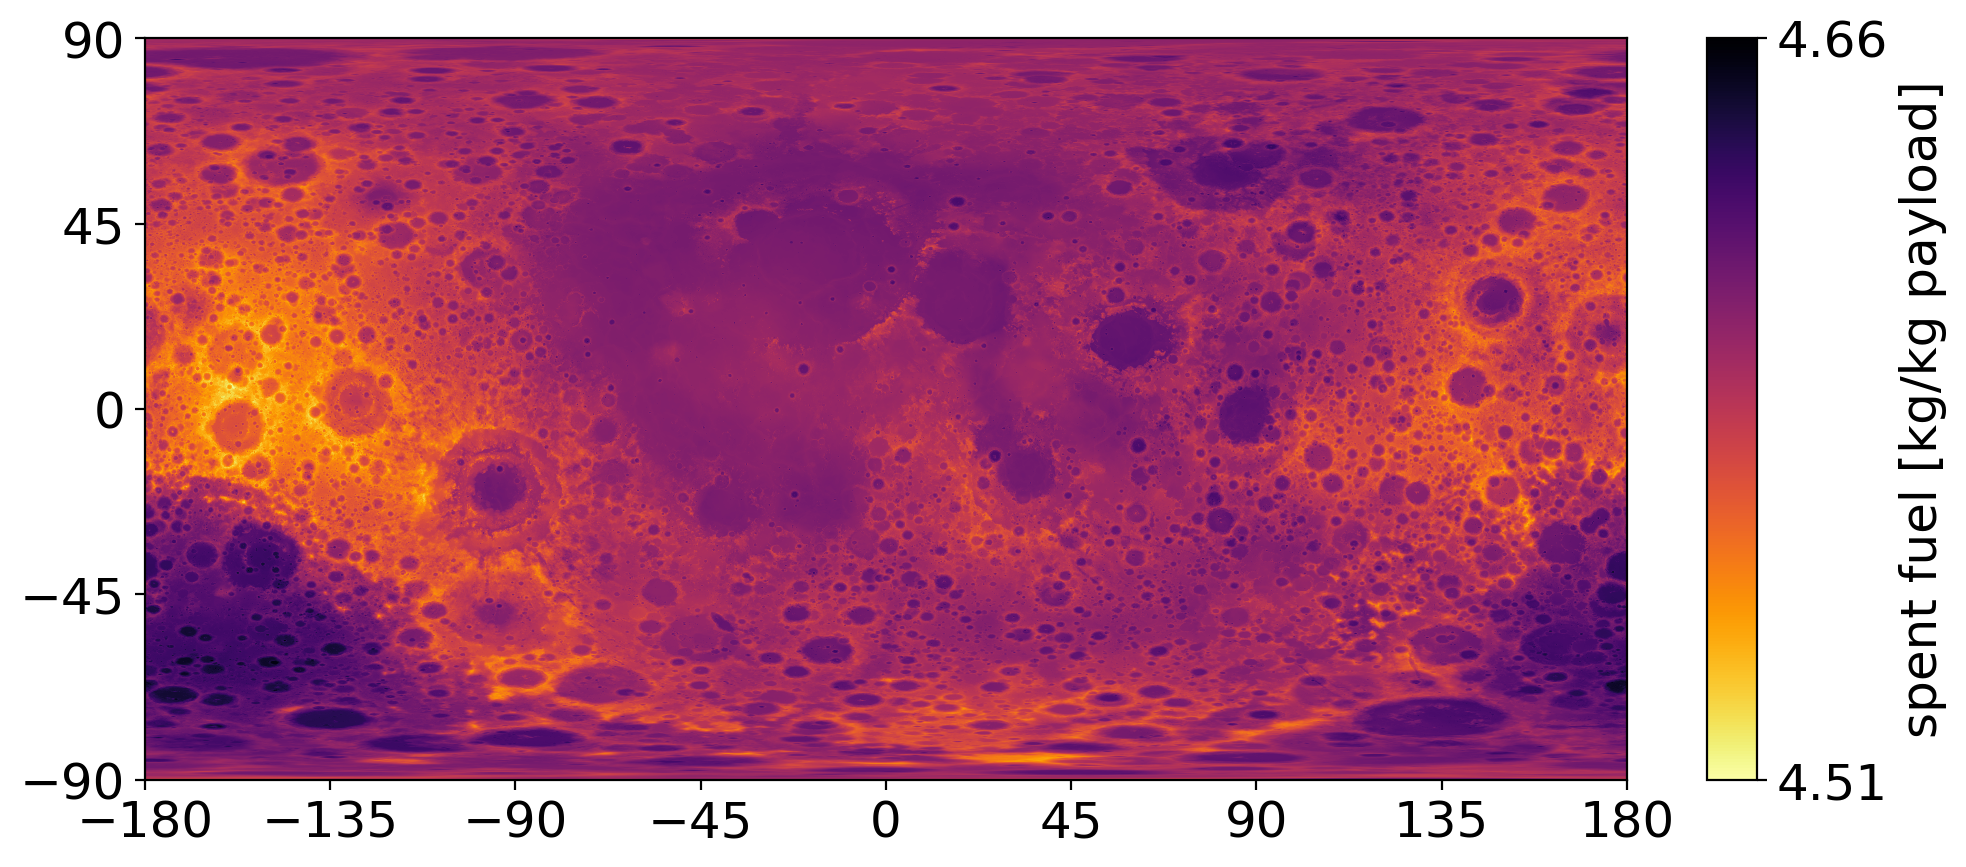

In [163]:
inferno = cm.get_cmap('inferno', 256)
newcolors = inferno(np.linspace(0, 1, 256))
newcmp = ListedColormap(np.flip(newcolors,axis=0))

plot_map(spent_fuel_NRHO_1_5,1,'spent fuel [kg/kg payload]',tuple((-90,90)),tuple((-180,180)),i_steps=[],cmap=newcmp,silent=True,labelsize=18,save="cost_map_NRHO_1_5.png")

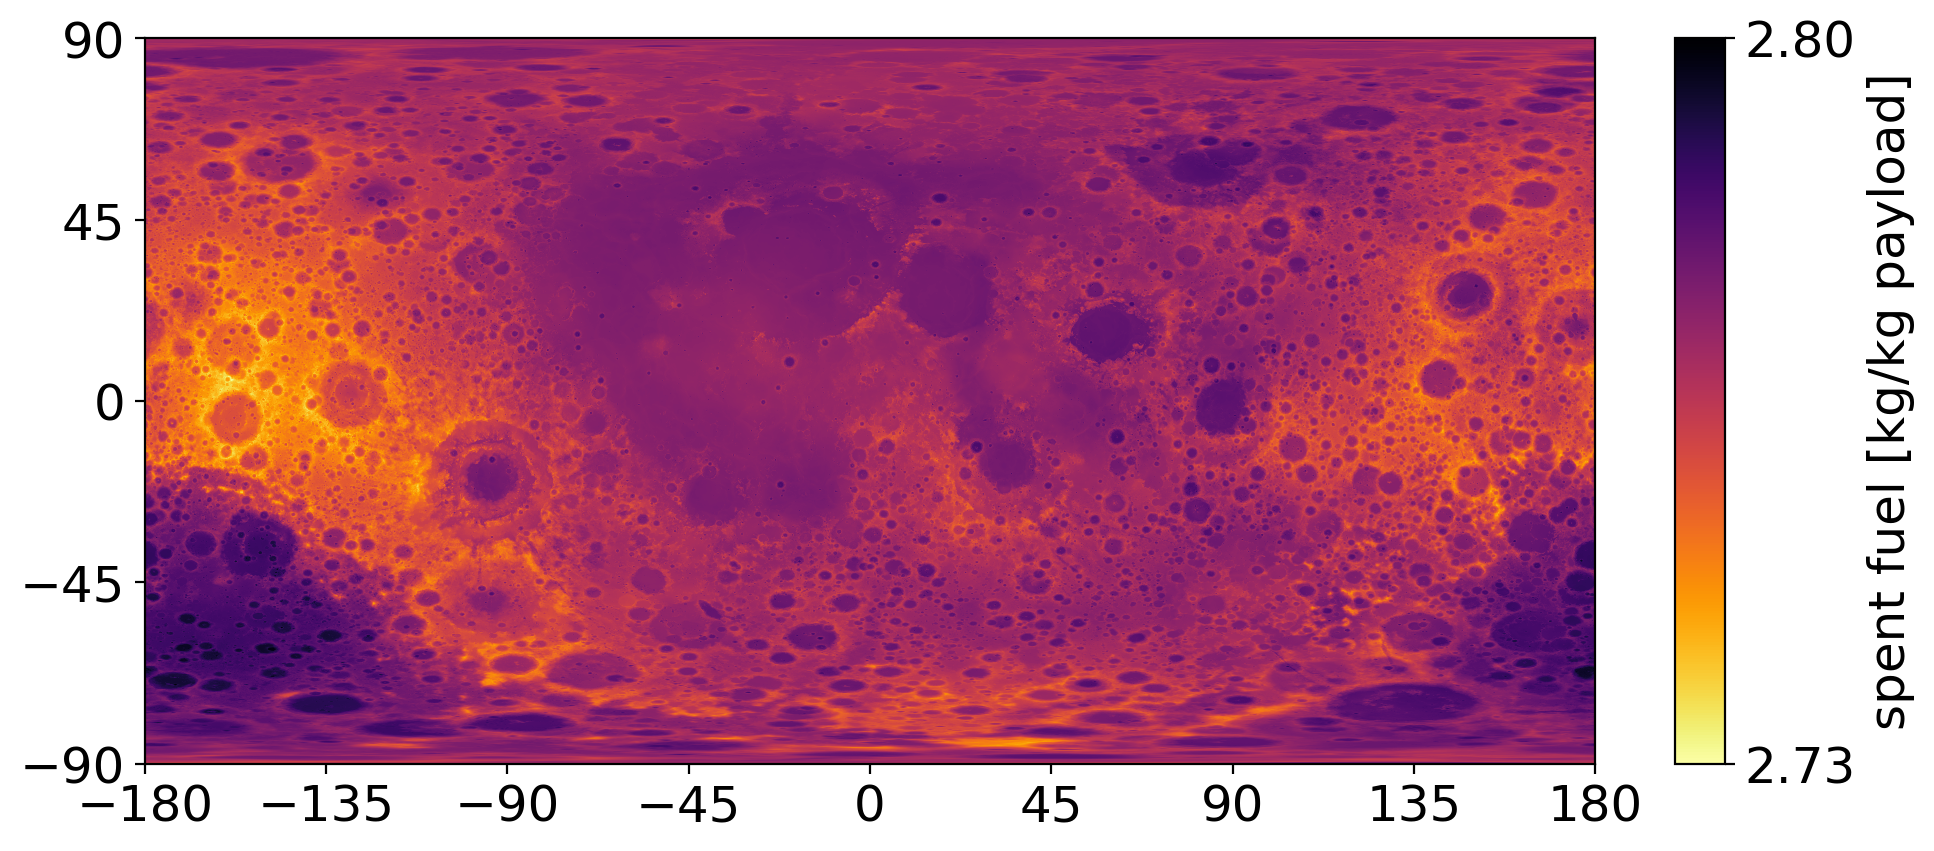

In [164]:
plot_map(spent_fuel_NRHO_2_5,1,'spent fuel [kg/kg payload]',tuple((-90,90)),tuple((-180,180)),i_steps=[],cmap=newcmp,silent=True,labelsize=18,save="cost_map_NRHO_2_5.png")

# Destination: Low Lunar Orbit (LLO) - Equatorial - 100km AltitudePolar - circular
Theoretical minimum via Hohmann-Transfers and impulsive maneuvers

| Maneuver | Description                                                            |
|-----------|------------------------------------------------------------------------|
| I         | a) Accelerate to orbital speed at h=0 from v0(Lat,Lon) <br> --> heading to equatorial crossing with minimal inclination change <br> b) Raise Apo to LLO   |
| II        | a) Inclination change to 0° <br> b) Raise Peri to LLO (circular)                                                     |

In [ ]:
orbital_r = r_moon + 100_000

### I) Ascent
- from h0,v0 to orbital speed on ground level
    - -> heading to equatorial crossing with minimal inclination change
- raise Apo to LLO

In [ ]:
# placeholder
def maneuver_I(start_r, start_vel):
    v0 = start_vel
    a = (start_r + orbital_r)/2 # [m] semi major axis of transfer ellipse to LLO
    v1 = orb_vel(start_r)
    v2_H1 = orb_vel_ellip(start_r,a) - orb_vel(start_r)
    
    dv_m1 = np.sqrt(v0**2 + (v1 + v2_H1)**2) # vector norm - v0 is not perpendicular to v1 and v2_H1
    return dv_m1 # [m/s]

### II) Plane Match & LLO circularization
- Inclination change to 0°
- Raise Peri to LLO (circular)

In [ ]:
# placeholder
def maneuver_II(start_r):
    a = (start_r + orbital_r)/2 # [m] semi major axis of transfer ellipse to LLO
    v2_H2 = orb_vel(orbital_r) - orb_vel_ellip(orbital_r,a)
    
    return v2_H2 # [m/s]

## Destination: Lagrange Point (L1) - Earth Moon System
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Low Earth Orbit (Equatorial) - Starship refuel
> open file "Gateway_PROP_Mass_Point.sc" in STK